In [21]:
import os, zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
from google.colab import drive

# 掛載 Google Drive
drive.mount('/content/drive', force_remount=True)

# 解壓縮資料
zip_path = '/content/drive/MyDrive/face_glasses.zip'
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [22]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_path = '/content/face_glasses/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

class_names = train_dataset.class_names
positive_idx = class_names.index("positive")
negative_idx = class_names.index("negative")

train_all = list(train_dataset.unbatch())
positive_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == positive_idx]
negative_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == negative_idx]

# 建立 VAE 訓練資料集（只用無眼鏡）
vae_train_dataset = tf.data.Dataset.from_tensor_slices([x for x, _ in negative_train])
vae_train_dataset = vae_train_dataset.map(lambda x: x / 255.0)
vae_train_dataset = vae_train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# 驗證集：positive 資料夾
val_path = '/content/face_glasses/validation/positive'
vae_val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels=None,
    label_mode=None,
    batch_size=1,
    image_size=IMG_SIZE,
    shuffle=False
).map(lambda x: x / 255.0)

print(f"✅ 訓練資料量（無眼鏡）: {len(negative_train)}")
print(f"✅ 預覽樣本（有眼鏡）: {len(positive_train)}")

Found 141 files belonging to 2 classes.
Found 20 files.
✅ 訓練資料量（無眼鏡）: 81
✅ 預覽樣本（有眼鏡）: 60


In [23]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

vgg = VGG19(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
vgg.trainable = False
vgg_feature_extractor = keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer("block3_conv3").output
)

In [24]:
# Sampling 層
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(160, 160, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(20 * 20 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((20, 20, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            real_features = vgg_feature_extractor(preprocess_input(data * 255.0))
            recon_features = vgg_feature_extractor(preprocess_input(reconstruction * 255.0))
            perceptual_loss = tf.reduce_mean(tf.square(real_features - recon_features))

            total_loss = reconstruction_loss + kl_loss + 0.1 * perceptual_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "perceptual_loss": perceptual_loss,
        }

In [26]:
import matplotlib.pyplot as plt

def plot_vae_loss(history):
    plt.figure(figsize=(10, 5))

    if "loss" in history.history:
        plt.plot(history.history["loss"], label="Total Loss", linewidth=2)
    if "reconstruction_loss" in history.history:
        plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss", linestyle="--")
    if "kl_loss" in history.history:
        plt.plot(history.history["kl_loss"], label="KL Loss", linestyle=":")
    if "perceptual_loss" in history.history:
        plt.plot(history.history["perceptual_loss"], label="Perceptual Loss", linestyle="-.")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - kl_loss: 18.8681 - loss: 21038.0996 - perceptual_loss: 168706.0625 - reconstruction_loss: 4482.5117
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - kl_loss: 32.6484 - loss: 20300.4707 - perceptual_loss: 158655.2969 - reconstruction_loss: 4522.9976
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - kl_loss: 512.9106 - loss: 19384.0000 - perceptual_loss: 142321.0781 - reconstruction_loss: 4702.0083
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - kl_loss: 88.2934 - loss: 17883.5254 - perceptual_loss: 133659.3750 - reconstruction_loss: 4623.4893
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - kl_loss: 127.2371 - loss: 17174.7832 - perceptual_loss: 125846.2344 - reconstruction_loss: 4769.1958
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - kl_loss: 57.5698 - loss: 16564.5254 - perceptual_loss: 122707.4453 - reconstruction_loss: 4669.8516
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - kl_loss: 41.9571 - loss: 16240.68

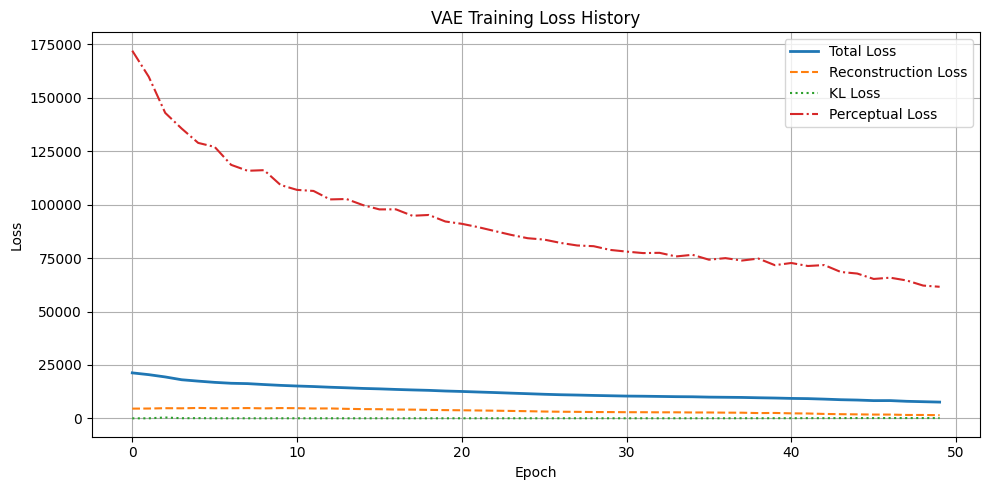

In [27]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(
    vae_train_dataset,
    epochs=50
)

plot_vae_loss(history)

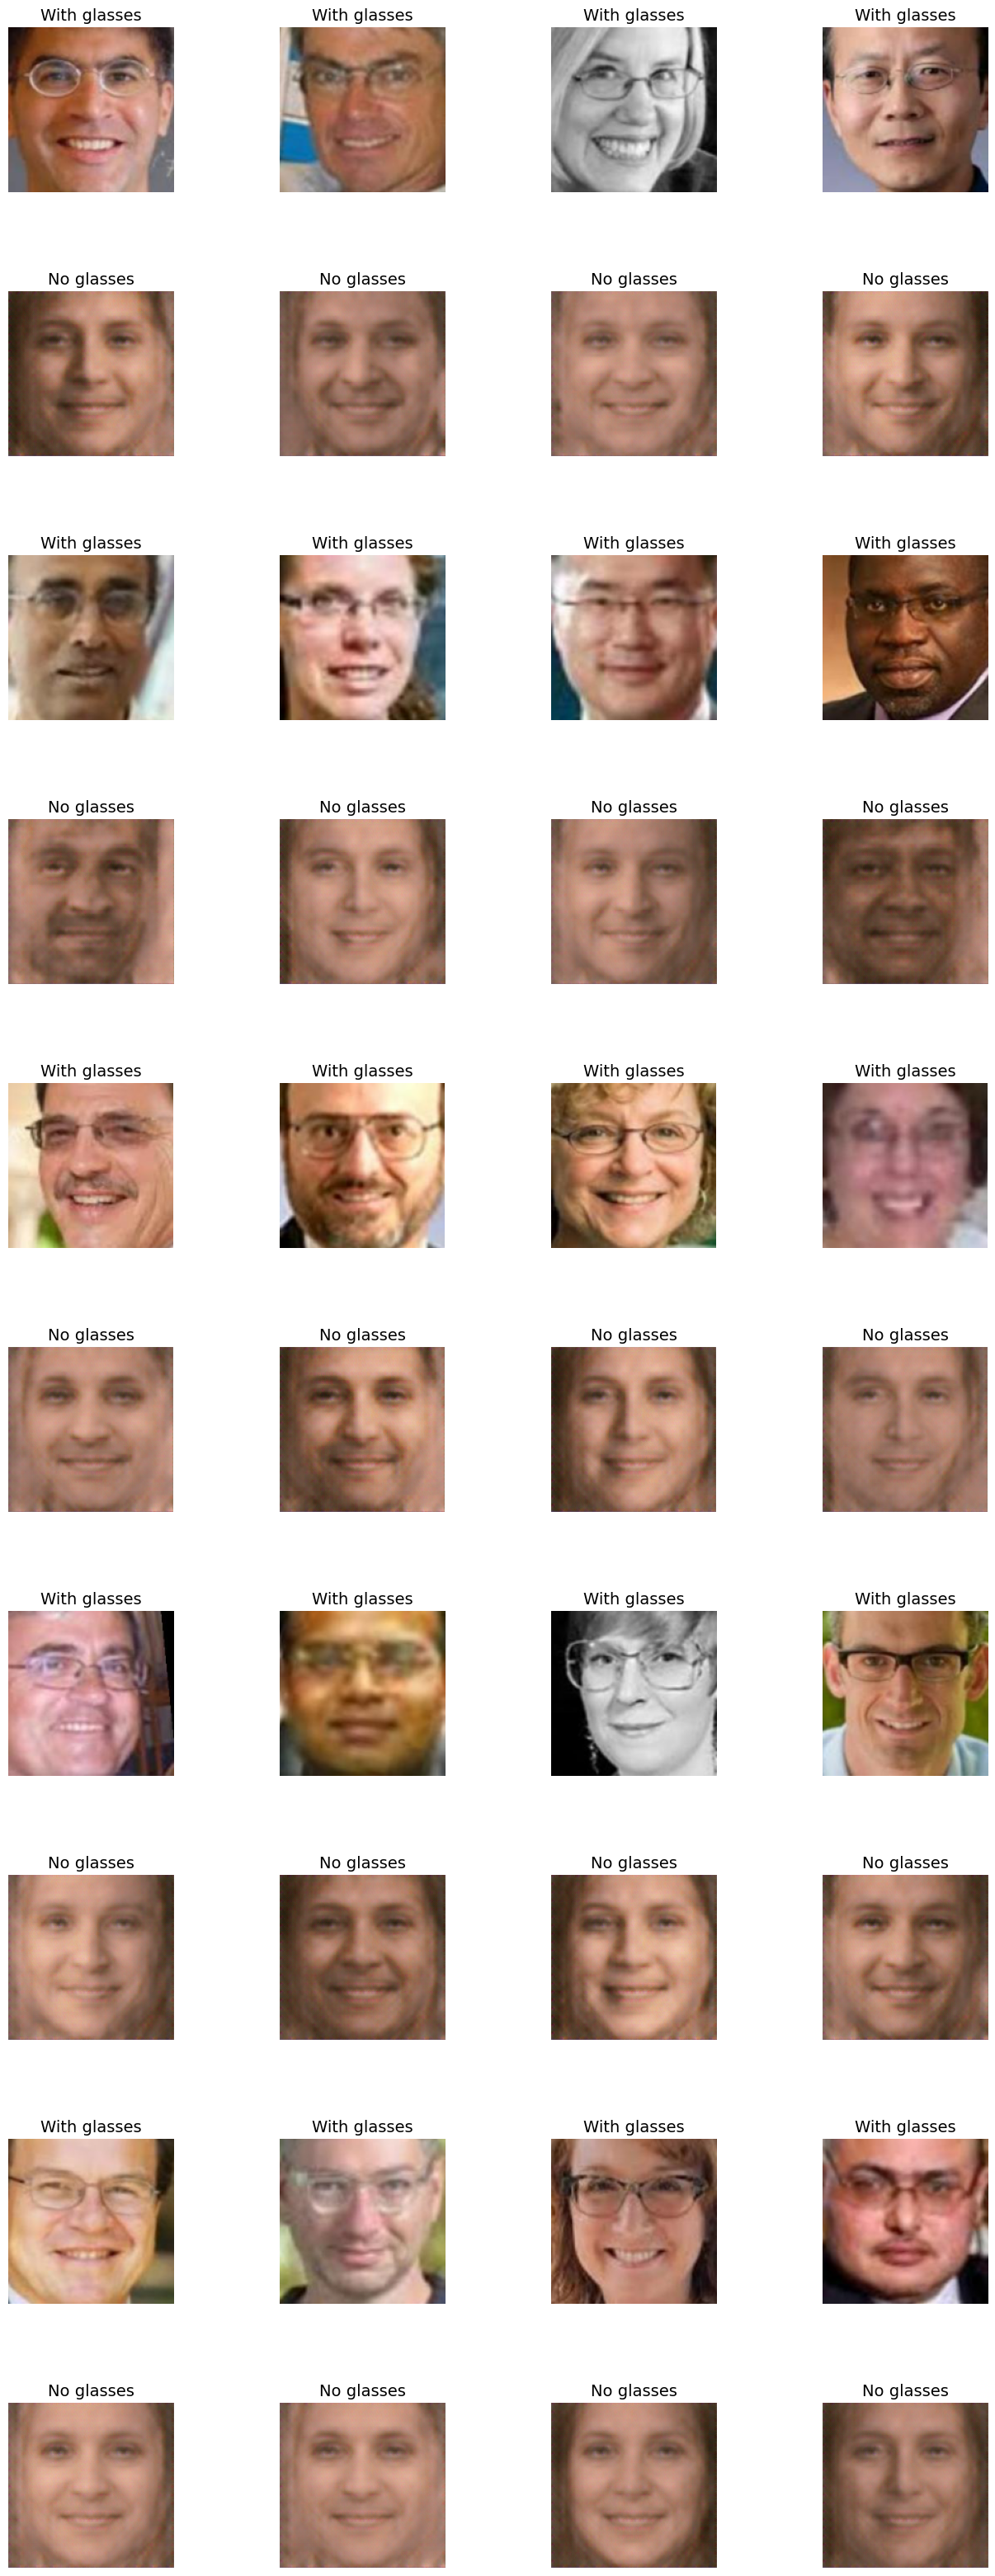

In [28]:
def show_reconstructions(vae_val_dataset, encoder, decoder, num_pairs=8, save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np

    assert num_pairs % 4 == 0, "num_pairs 必須是 4 的倍數"

    cols = 4
    rows = (num_pairs // cols) * 2  # 每組佔兩排：原圖 + 重建

    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    for i, sample in enumerate(vae_val_dataset.take(num_pairs)):
        z_mean, z_log_var, z = encoder.predict(sample, verbose=0)
        reconstructed = decoder.predict(z, verbose=0)

        row = (i // cols) * 2
        col = i % cols

        axs[row, col].imshow(sample[0])
        axs[row, col].set_title("With glasses", fontsize=14)
        axs[row, col].axis("off")

        axs[row + 1, col].imshow(np.clip(reconstructed[0], 0, 1))
        axs[row + 1, col].set_title("No glasses", fontsize=14)
        axs[row + 1, col].axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"✅ 已儲存圖檔至：{save_path}")

    plt.show()

    # 顯示 8 組原圖+重建圖
show_reconstructions(vae_val_dataset, encoder, decoder, num_pairs=20)
